# Variant functional consequences

This notebook provides a summary of the functional consequences of lead variants


## Data Loading

The data required for the analysis is loaded from the `computed maf` dataset.


In [11]:
from __future__ import annotations

import plotnine as pn
from gentropy.common.session import Session
from pyspark.sql import Column, Window
from pyspark.sql import functions as f

from manuscript_methods.datasets import LeadVariantEffect


In [2]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
lead_maf_dataset_path = "../../data/lead-maf-vep"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/25 09:24:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/25 09:24:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
session.spark


In [4]:
dataset_maf = LeadVariantEffect.from_parquet(session, lead_maf_dataset_path)


In [5]:
## Pre filter the dataset for maf and rescaled effect size
dataset = dataset_maf.effect_size_filter().maf_filter()


In [6]:
maf_vep_dataset = dataset.df.select(
    "variantId",
    "leadVariantConsequence.*",
    "studyStatistics.studyType",
    "majorLdPopulationMaf.value",
    "rescaledStatistics.*",
).select("variantId", "type", "transcriptConsequence.consequenceScore", "studyType", "value", "estimatedBeta")
maf_vep_dataset.show()


+--------------------+--------------+----------------+---------+--------------------+--------------------+
|           variantId|          type|consequenceScore|studyType|               value|       estimatedBeta|
+--------------------+--------------+----------------+---------+--------------------+--------------------+
|     19_54047861_G_T|in-gene-effect|             0.0|     eqtl|  0.4566601804351672| -0.9566133075133585|
|     1_203065181_G_A|       unknown|             0.1|     gwas|  0.3418860064381746|-0.04127007017402...|
|      6_45904593_G_T|       unknown|             0.1|     gwas|  0.4577639506950734| 0.01374365235104728|
|     22_23924539_T_C|in-gene-effect|             0.0|     eqtl| 0.41338513155571255|  1.6566464125362077|
|    6_109051163_C_CA|       unknown|             0.1|     gwas|  0.1237482964981928| 0.10404139199374728|
|      19_3062695_C_T|in-gene-effect|             0.0|     sqtl|0.029772110554543974| -1.3500406409263206|
|    5_180820102_CG_C|in-gene-effect|

## Methods

- Calculate the proportion of altering / non-altering variants


In [9]:
def calculate_protein_altering_proportion(vep_score: Column, threshold: float = 0.66) -> Column:
    """Calculate the proportion of protein-altering variants in each bucket."""
    w = Window.partitionBy("bucket", "studyType").orderBy("bucket", "studyType")
    n_protein_altering = f.count(f.when(vep_score >= threshold, 1)).over(w).alias("nAlteringInBucket")
    n_non_protein_altering = f.count(f.when(vep_score < threshold, 1)).over(w).alias("nNonAlteringInBucket")
    proportion = (n_protein_altering / n_non_protein_altering).alias("alteringNonAlteringProportionInBucket")
    stderr = f.sqrt((proportion * (1 - proportion)) / (n_protein_altering + n_non_protein_altering)).alias("stdErr")
    total = (n_protein_altering + n_non_protein_altering).alias("totalInBucket")
    return f.struct(n_protein_altering, n_non_protein_altering, proportion, stderr, total)


## Proportion of altering / non altering vs maf bins


In [12]:
PRECISION = 10  # Needs to be the power of 10
PRECISION_FACTOR = len(str(PRECISION)) - 1  # Number of digits in the precision factor
upper_limit = f.ceil(f.col("value") * PRECISION) / PRECISION
lower_limit = f.floor(f.col("value") * PRECISION) / PRECISION

bucket_dataset = (
    maf_vep_dataset.withColumns(
        {
            "minRange": f.round(
                f.when(upper_limit == lower_limit, lower_limit - 1 / PRECISION).otherwise(lower_limit), PRECISION_FACTOR
            ),
            "maxRange": upper_limit,
        }
    )
    .withColumn("midPoint", f.round((f.col("minRange") + f.col("maxRange")) / 2, PRECISION_FACTOR + 1))
    .withColumn("bucket", f.concat(f.col("minRange"), f.lit("-"), f.col("maxRange")))
    .withColumn("vepProportion", calculate_protein_altering_proportion(f.col("consequenceScore")))
    .orderBy("bucket")
    .select(
        "variantId",
        "type",
        "vepProportion.*",
        "consequenceScore",
        "studyType",
        "bucket",
        f.col("value").alias("MAF"),
        "minRange",
        "maxRange",
        "midPoint",
    )
)

bucket_dataset.filter(f.col("value") == 0.5).show(truncate=False)


+------------------+--------------+-----------------+--------------------+-------------------------------------+---------------------+-------------+----------------+---------+-------+---+--------+--------+--------+
|variantId         |type          |nAlteringInBucket|nNonAlteringInBucket|alteringNonAlteringProportionInBucket|stdErr               |totalInBucket|consequenceScore|studyType|bucket |MAF|minRange|maxRange|midPoint|
+------------------+--------------+-----------------+--------------------+-------------------------------------+---------------------+-------------+----------------+---------+-------+---+--------+--------+--------+
|15_34573266_T_C   |in-gene-effect|3188             |264208              |0.012066250832677285                 |2.1114102829194678E-4|267396       |0.1             |eqtl     |0.4-0.5|0.5|0.4     |0.5     |0.45    |
|16_88484674_A_G   |unknown       |5455             |139942              |0.03898043475153992                  |5.075884497916845E-4 |145397

In [13]:
data = bucket_dataset.drop_duplicates(["bucket", "studyType"]).toPandas()


25/06/25 09:26:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [14]:
data


,variantId,type,nAlteringInBucket,nNonAlteringInBucket,alteringNonAlteringProportionInBucket,stdErr,totalInBucket,consequenceScore,studyType,bucket,MAF,minRange,maxRange,midPoint
0,1_175067580_C_T,in-gene-effect,1082,8232,0.131438,0.003501,9314,0.00,cis-pqtl,0.0-0.1,0.001869,0.0,0.1,0.05
1,7_92465033_T_C,in-gene-effect,5948,249704,0.023820,0.000302,255652,0.00,eqtl,0.0-0.1,0.021359,0.0,0.1,0.05
2,15_52730391_C_T,unknown,27132,177012,0.153278,0.000797,204144,0.00,gwas,0.0-0.1,0.065889,0.0,0.1,0.05
3,2_3576461_C_A,in-gene-effect,131,6467,0.020257,0.001734,6598,0.10,sceqtl,0.0-0.1,0.072760,0.0,0.1,0.05
4,19_3062695_C_T,in-gene-effect,2360,38405,0.061450,0.001189,40765,0.00,sqtl,0.0-0.1,0.029772,0.0,0.1,0.05
5,4_101829857_G_C,out-of-gene-effect,1339,4005,0.334332,0.006453,5344,0.66,trans-pqtl,0.0-0.1,0.019592,0.0,0.1,0.05
6,11_798254_C_A,in-gene-effect,3049,68394,0.044580,0.000772,71443,0.00,tuqtl,0.0-0.1,0.015840,0.0,0.1,0.05
7,17_47652097_G_A,out-of-gene-effect,134,1746,0.076747,0.006139,1880,0.10,cis-pqtl,0.1-0.2,0.124761,0.1,0.2,0.15
8,20_3230658_G_A,in-gene-effect,4613,248992,0.018527,0.000268,253605,0.33,eqtl,0.1-0.2,0.133193,0.1,0.2,0.15
9,6_109051163_C_CA,unknown,5645,116656,0.048390,0.000614,122301,0.10,gwas,0.1-0.2,0.123748,0.1,0.2,0.15


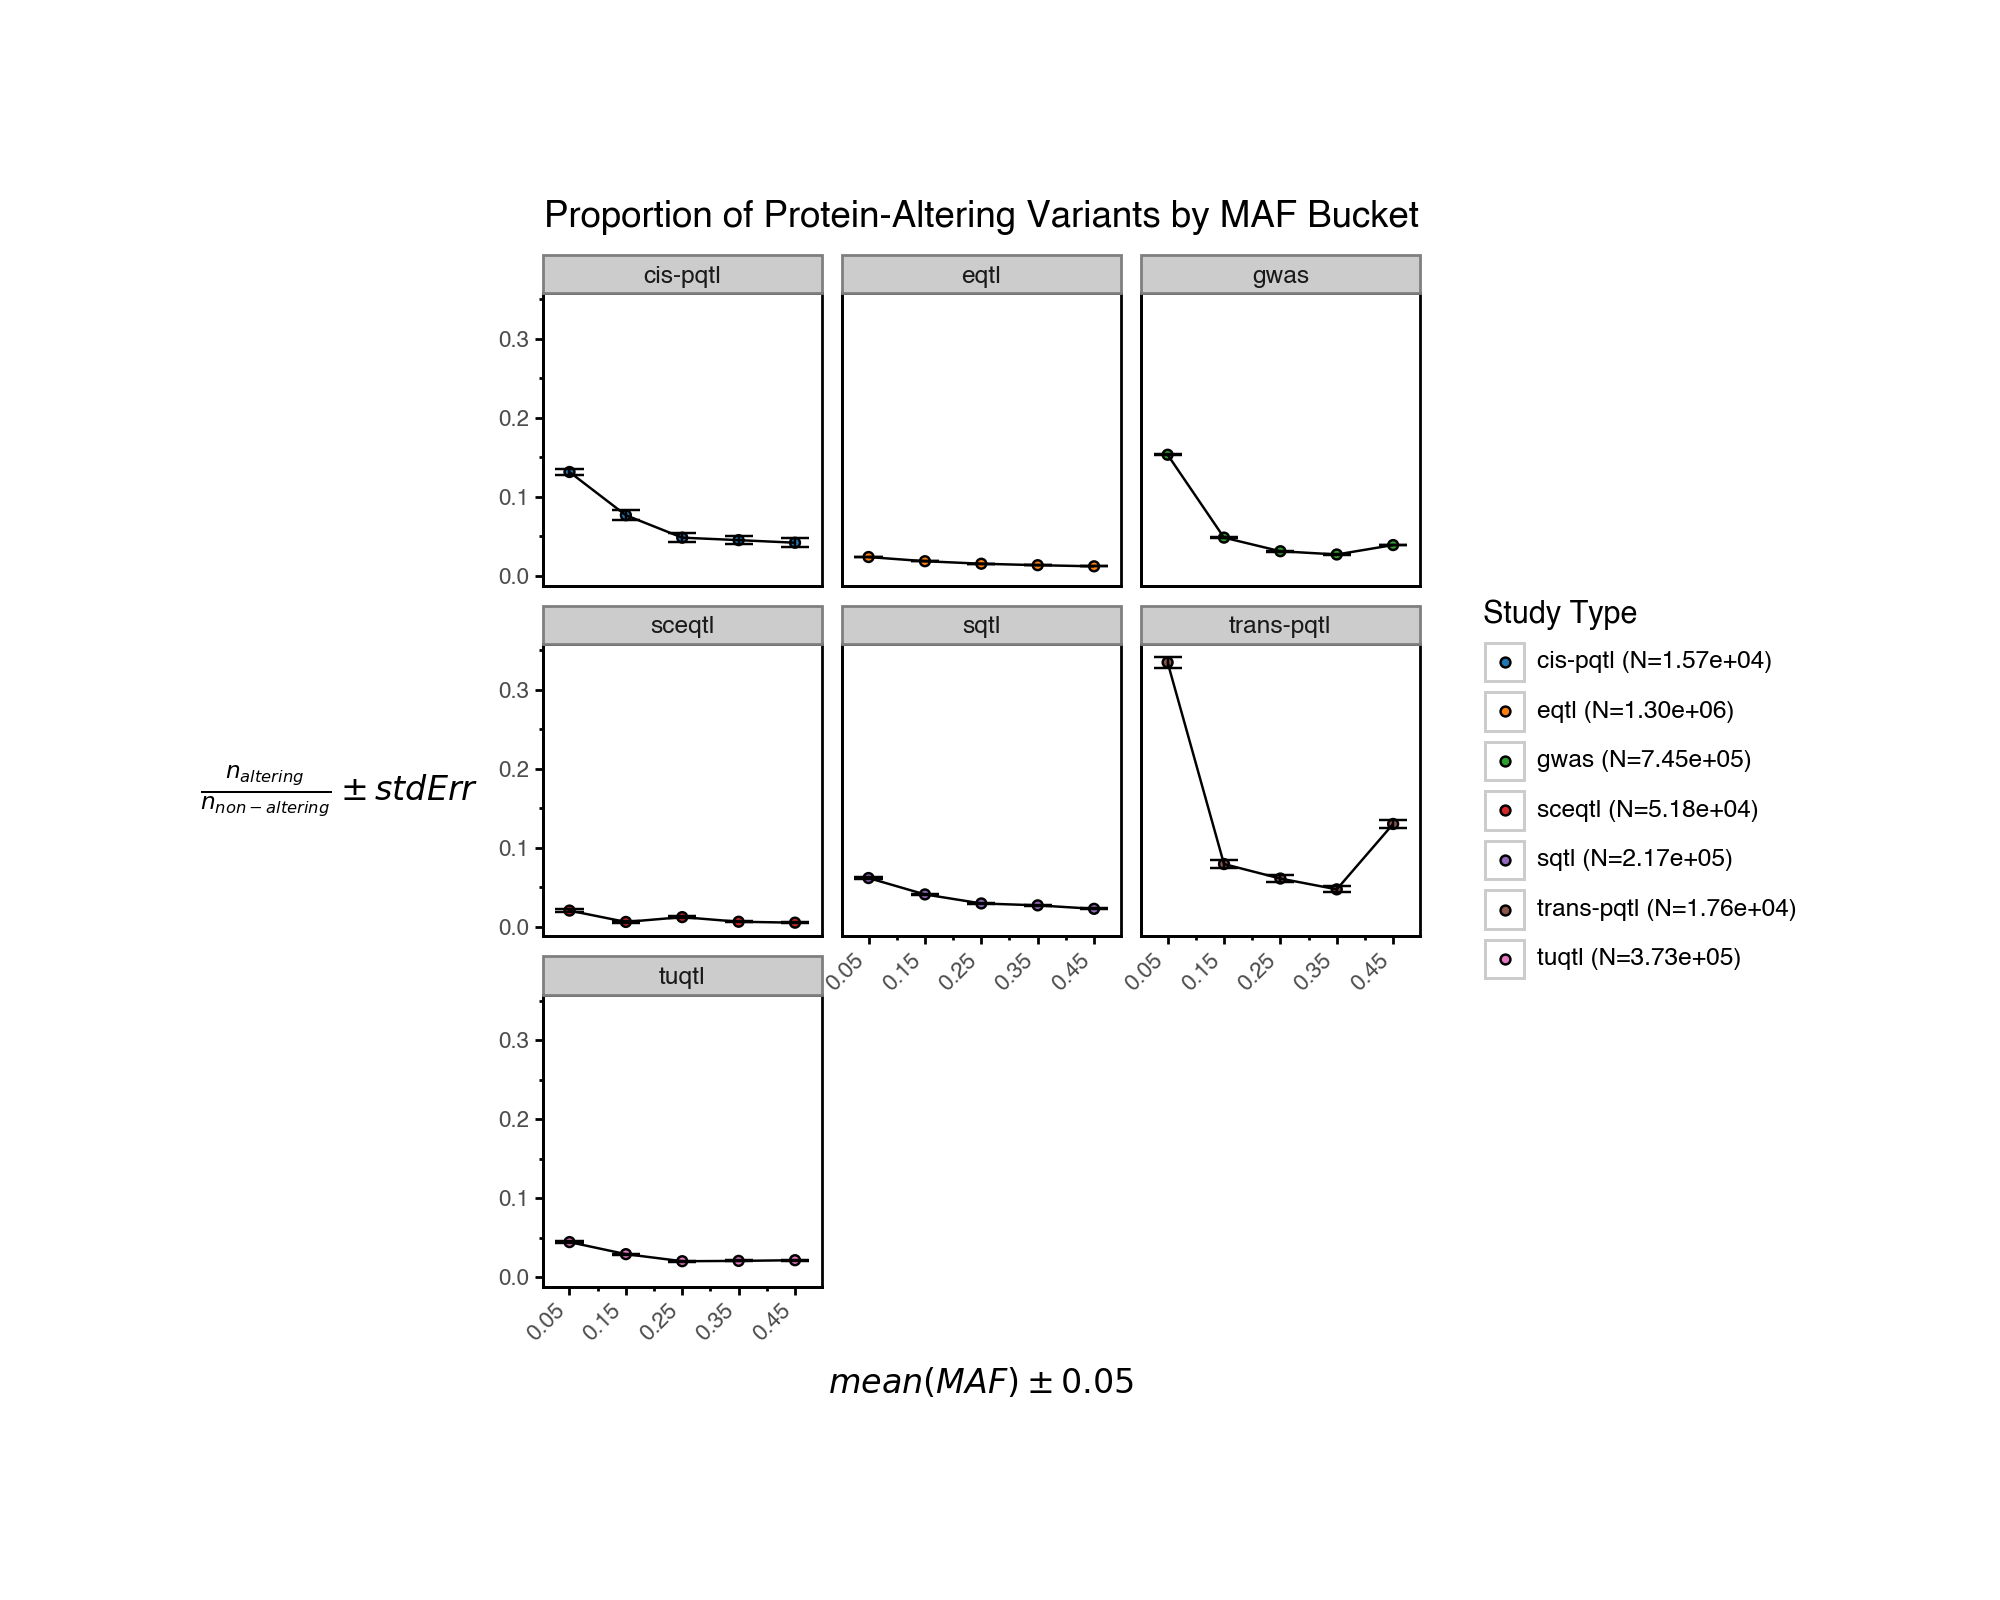

In [ ]:
study_type_totals = data.groupby("studyType")["totalInBucket"].sum()
totals_map = {cat: f"{cat} (N={study_type_totals[cat]:.2e})" for cat in study_type_totals.index}
REM = 10
plot = (
    pn.ggplot(
        data,
        pn.aes(
            x="midPoint",
            y="alteringNonAlteringProportionInBucket",
            fill="studyType",
        ),
    )
    + pn.geom_point()
    + pn.geom_errorbar(
        pn.aes(
            ymin="alteringNonAlteringProportionInBucket - stdErr",
            ymax="alteringNonAlteringProportionInBucket + stdErr",
        ),
        width=0.05,
    )
    + pn.theme_bw()
    + pn.labs(
        title="Proportion of Protein-Altering Variants by MAF Bucket",
        x=r"$mean(MAF)\pm{0.05}$",
        y=r"$\frac{n_{altering}}{n_{non-altering}}\pm{stdErr}$ ",
    )
    + pn.scale_x_continuous(
        breaks=[x for x in data["midPoint"].unique()],
        labels=[x for x in data["midPoint"].unique()],
    )
    + pn.theme(
        figure_size=(10, 8),  # ~85mm wide
        axis_title_x=pn.element_text(size=REM * 1.2, family="sans-serif"),
        axis_text=pn.element_text(size=REM * 0.8, family="sans-serif"),
        axis_title_y=pn.element_text(size=REM * 1.2, family="sans-serif", rotation=0, vjust=0.5),
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        axis_ticks=pn.element_line(color="black"),
        axis_line=pn.element_line(color="black"),
        panel_background=pn.element_rect(fill="white"),
        panel_border=pn.element_rect(color="black", fill=None),
        panel_grid=pn.element_blank(),
        plot_margin=0.1,
    )
    + pn.facet_wrap(nrow=3, ncol=3, facets="studyType")
    + pn.geom_line()
    + pn.scale_fill_manual(
        values=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"],
        name="Study Type",
        labels=totals_map,
    )
)
plot


### variant counts


In [20]:
dataset_maf.df.groupBy("studyStatistics.studyType").agg(
    f.format_number(f.count("variantId"), 2).alias("totalVariants")
).show()


+----------+-------------+
| studyType|totalVariants|
+----------+-------------+
|  cis-pqtl|    16,053.00|
|      gwas|   789,453.00|
|      sqtl|   223,500.00|
|     tuqtl|   384,852.00|
|      eqtl| 1,349,478.00|
|trans-pqtl|    17,678.00|
|    sceqtl|    52,744.00|
+----------+-------------+



## Proportion of altering / non altering vs abs(estimatedBeta)


In [64]:
PRECISION = 2  # Needs to be the power of 10
PRECISION_FACTOR = len(str(PRECISION)) - 1  # Number of digits in the precision factor
upper_limit = f.ceil(f.col("absEstimatedBeta") * PRECISION) / PRECISION
lower_limit = f.floor(f.col("absEstimatedBeta") * PRECISION) / PRECISION

bucket_dataset = (
    maf_vep_dataset.withColumn("absEstimatedBeta", f.abs("estimatedBeta"))
    .withColumns(
        {
            "minRange": f.when(upper_limit == lower_limit, lower_limit - 1 / PRECISION).otherwise(lower_limit),
            "maxRange": upper_limit,
        }
    )
    .withColumn("midPoint", f.round((f.col("minRange") + f.col("maxRange")) / 2, PRECISION_FACTOR + 2))
    .withColumn("bucket", f.concat(f.col("minRange"), f.lit("-"), f.col("maxRange")))
    .withColumn("vepProportion", calculate_protein_altering_proportion(f.col("consequenceScore")))
    .orderBy("bucket")
    .select(
        "variantId",
        "type",
        "vepProportion.*",
        "consequenceScore",
        "studyType",
        "bucket",
        "absEstimatedBeta",
        "minRange",
        "maxRange",
        "midPoint",
    )
)


In [65]:
data = bucket_dataset.drop_duplicates(["bucket", "studyType"]).toPandas()
data


,variantId,type,nAlteringInBucket,nNonAlteringInBucket,alteringNonAlteringProportionInBucket,stdErr,totalInBucket,consequenceScore,studyType,bucket,absEstimatedBeta,minRange,maxRange,midPoint
0,17_47652097_G_A,out-of-gene-effect,620,10947,0.056637,0.002149,11567,0.10,cis-pqtl,0.0-0.5,0.122756,0.0,0.5,0.25
1,2_111764320_A_G,in-gene-effect,1920,212011,0.009056,0.000205,213931,0.00,eqtl,0.0-0.5,0.393972,0.0,0.5,0.25
2,1_203065181_G_A,unknown,41755,656740,0.063579,0.000292,698495,0.10,gwas,0.0-0.5,0.041270,0.0,0.5,0.25
3,12_121774846_G_T,in-gene-effect,56,10007,0.005596,0.000744,10063,0.00,sceqtl,0.0-0.5,0.289977,0.0,0.5,0.25
4,1_23638625_A_G,in-gene-effect,532,35654,0.014921,0.000637,36186,0.10,sqtl,0.0-0.5,0.418594,0.0,0.5,0.25
5,7_95324583_G_A,out-of-gene-effect,1988,14527,0.136849,0.002674,16515,0.00,trans-pqtl,0.0-0.5,0.085414,0.0,0.5,0.25
6,8_11832254_G_A,in-gene-effect,883,61095,0.014453,0.000479,61978,0.00,tuqtl,0.0-0.5,0.345304,0.0,0.5,0.25
7,15_71969145_G_A,out-of-gene-effect,413,2554,0.161707,0.006759,2967,0.10,cis-pqtl,0.5-1.0,0.903604,0.5,1.0,0.75
8,19_54047861_G_T,in-gene-effect,9082,659771,0.013765,0.000142,668853,0.00,eqtl,0.5-1.0,0.956613,0.5,1.0,0.75
9,15_28116161_C_T,unknown,2485,17884,0.138951,0.002424,20369,0.10,gwas,0.5-1.0,0.804004,0.5,1.0,0.75


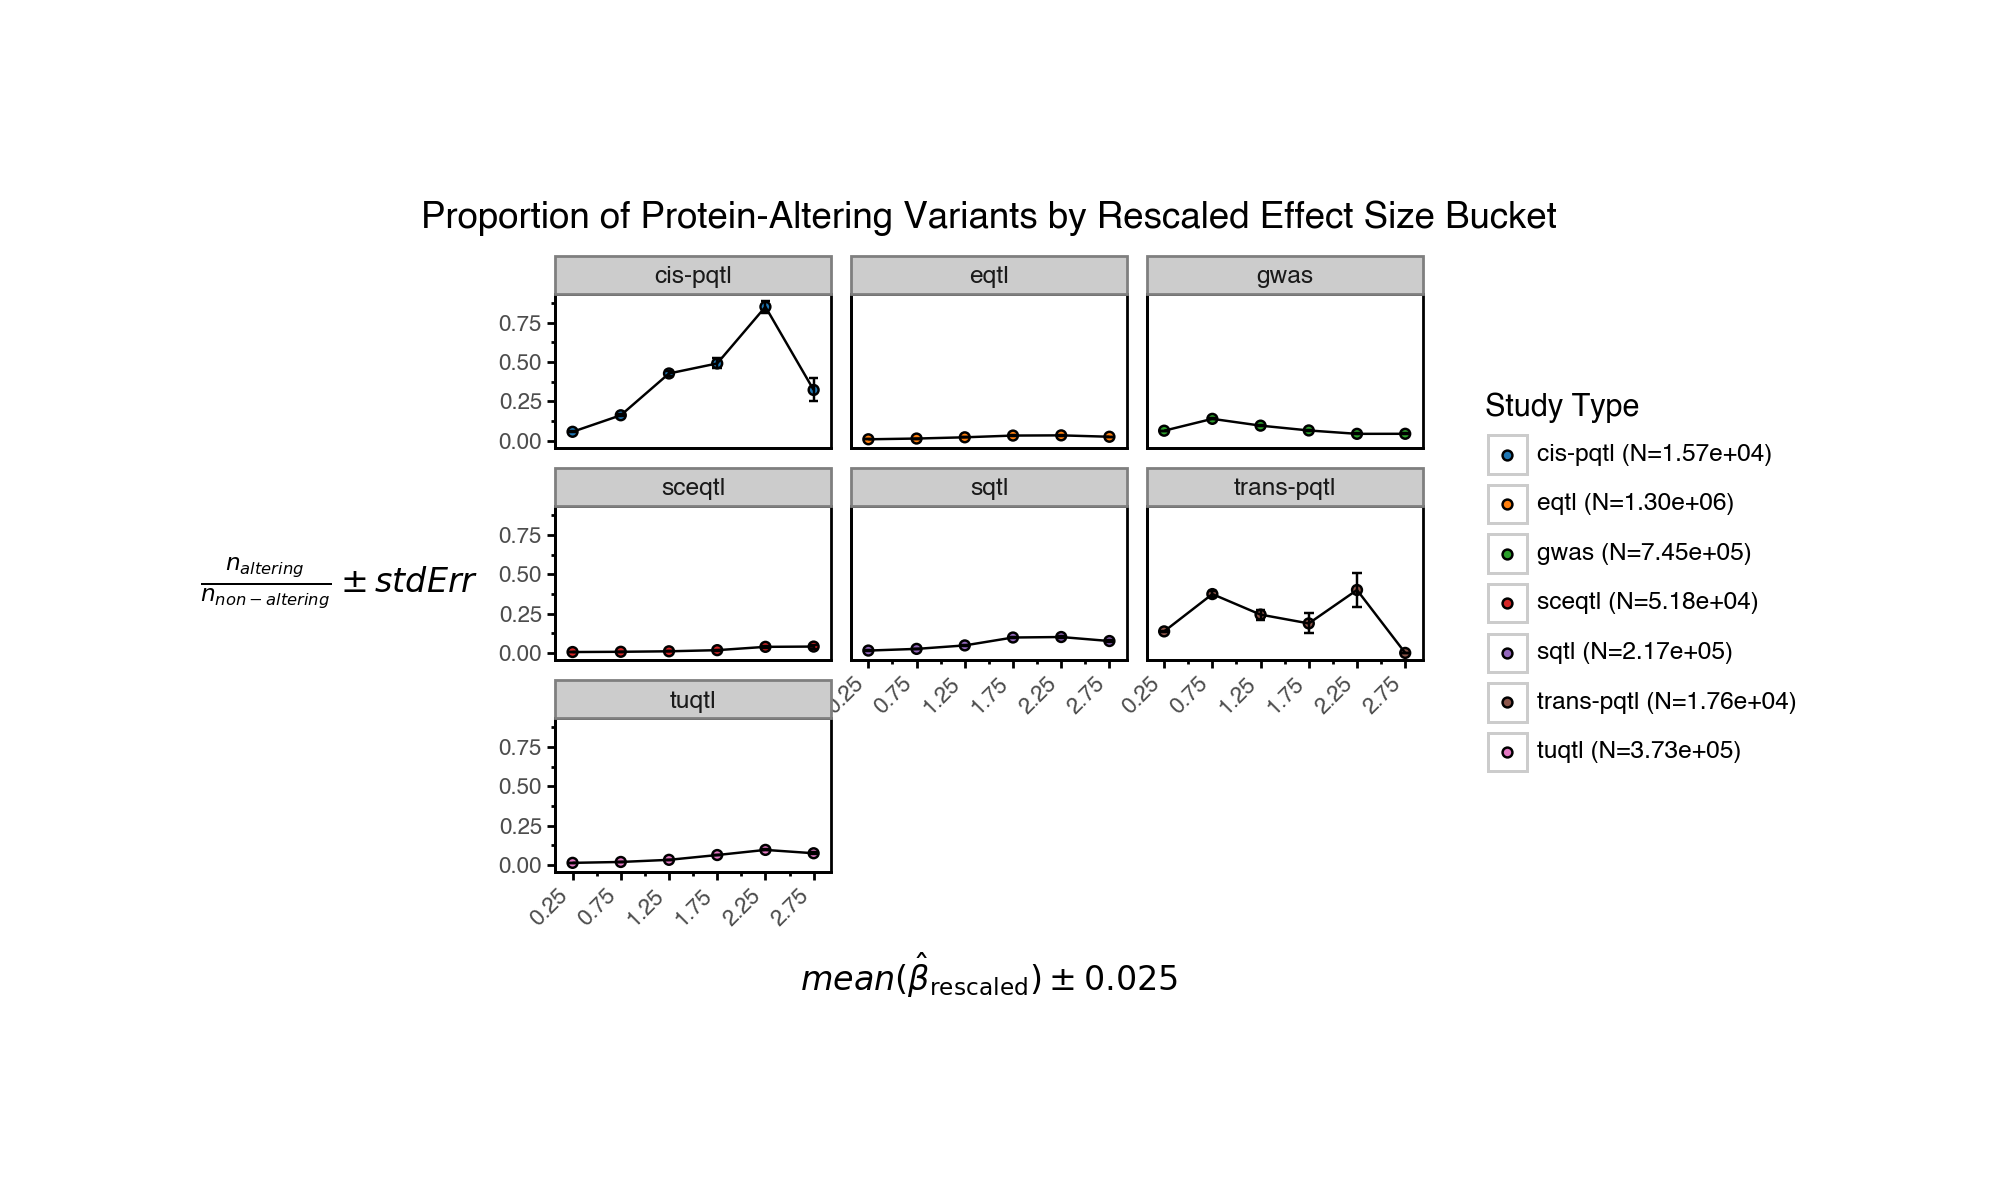

In [66]:
study_type_totals = data.groupby("studyType")["totalInBucket"].sum()
totals_map = {cat: f"{cat} (N={study_type_totals[cat]:.2e})" for cat in study_type_totals.index}
REM = 10
plot = (
    pn.ggplot(
        data,
        pn.aes(
            x="midPoint",
            y="alteringNonAlteringProportionInBucket",
            fill="studyType",
        ),
    )
    + pn.geom_point()
    + pn.geom_errorbar(
        pn.aes(
            ymin="alteringNonAlteringProportionInBucket - stdErr",
            ymax="alteringNonAlteringProportionInBucket + stdErr",
        ),
        width=0.1,
    )
    + pn.theme_bw()
    + pn.labs(
        title="Proportion of Protein-Altering Variants by Rescaled Effect Size Bucket",
        x=r"$mean(\hat{\beta}_{\mathrm{rescaled}})\pm{0.025}$",
        y=r"$\frac{n_{altering}}{n_{non-altering}}\pm{stdErr}$ ",
    )
    + pn.scale_x_continuous(
        breaks=[x for x in data["midPoint"].unique()],
        labels=[x for x in data["midPoint"].unique()],
    )
    + pn.theme(
        figure_size=(10, 6),  # ~85mm wide
        axis_title_x=pn.element_text(size=REM * 1.2, family="sans-serif"),
        axis_text=pn.element_text(size=REM * 0.8, family="sans-serif"),
        axis_title_y=pn.element_text(size=REM * 1.2, family="sans-serif", rotation=0, vjust=0.5),
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        axis_ticks=pn.element_line(color="black"),
        axis_line=pn.element_line(color="black"),
        panel_background=pn.element_rect(fill="white"),
        panel_border=pn.element_rect(color="black", fill=None),
        panel_grid=pn.element_blank(),
        plot_margin=0.1,
    )
    + pn.facet_wrap(nrow=3, ncol=3, facets="studyType")
    + pn.geom_line()
    + pn.scale_fill_manual(
        values=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"],
        name="Study Type",
        labels=totals_map,
    )
)
plot


## MAF vs protein altering - VEP score & abs(Beta) \w replicated GWAS credible sets


In [59]:
# Get the replicated GWAS credible sets


def weighted_mean(val: Column, weight) -> Column:
    """Calculate the weighted mean of a column."""
    return f.sum(val * weight) / f.sum(weight)


def weighted_se(weight: Column) -> Column:
    """Calculate the weighted standard deviation of a column."""
    return f.sqrt(1 / f.sum(weight))


replicated_gwas_credible_sets = (
    (
        dataset.replicated()
        .select(
            "variantId",
            "leadVariantConsequence.*",
            "studyStatistics.studyType",
            "majorLdPopulationMaf.value",
            "rescaledStatistics.*",
        )
        .select(
            "variantId",
            "type",
            "transcriptConsequence.consequenceScore",
            "studyType",
            f.col("value").alias("MAF"),
            "estimatedSE",
            f.abs("estimatedBeta").alias("absEstimatedBeta"),
            (f.lit(1) / (f.col("estimatedSE") * f.col("estimatedSE"))).alias("estBetaWeight"),
        )
    )
    .groupBy("studyType", "consequenceScore")
    .agg(
        f.mean("MAF").alias("meanMAF"),
        (f.stddev("MAF") / f.sqrt(f.count("MAF"))).alias("stdErrMAF"),
        weighted_mean(f.col("absEstimatedBeta"), f.col("estBetaWeight")).alias("WeightedMeanAbsEstimatedBeta"),
        weighted_se(f.col("estBetaWeight")).alias("WeightedSEAbsEstimatedBeta"),
        f.mean("absEstimatedBeta").alias("MeanAbsEstimatedBeta"),
        (f.stddev("absEstimatedBeta") / f.sqrt(f.count("absEstimatedBeta"))).alias("StdErrAbsEstimatedBeta"),
        f.count("variantId").alias("nCredibleSets"),
    )
    .orderBy("studyType", f.desc("consequenceScore"))
)

replicated_gwas_credible_sets.filter(f.col("studyType") == "gwas").show(truncate=False)


25/06/25 11:07:24 WARN CacheManager: Asked to cache already cached data.
25/06/25 11:07:24 WARN CacheManager: Asked to cache already cached data.


Initial number of variants: 2720012
Following number of variants: 88109
Number of variants removed: 2631903
Percentage of variants removed: 96.76%


+---------+----------------+-------------------+---------------------+----------------------------+--------------------------+--------------------+----------------------+-------------+
|studyType|consequenceScore|meanMAF            |stdErrMAF            |WeightedMeanAbsEstimatedBeta|WeightedSEAbsEstimatedBeta|MeanAbsEstimatedBeta|StdErrAbsEstimatedBeta|nCredibleSets|
+---------+----------------+-------------------+---------------------+----------------------------+--------------------------+--------------------+----------------------+-------------+
|gwas     |1.0             |0.06090665940012458|0.007444605243459026 |0.05917852452490129         |4.7754676321900235E-4     |0.4275280177850805  |0.0320210830825472    |278          |
|gwas     |0.66            |0.10074293352607788|0.0018575578224370106|0.04379122268334652         |7.352465237154914E-5      |0.22459687222598915 |0.004823584709469625  |5198         |
|gwas     |0.33            |0.16931391456088785|0.00612012297328688  |0.034

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 2 rows containing missing values.


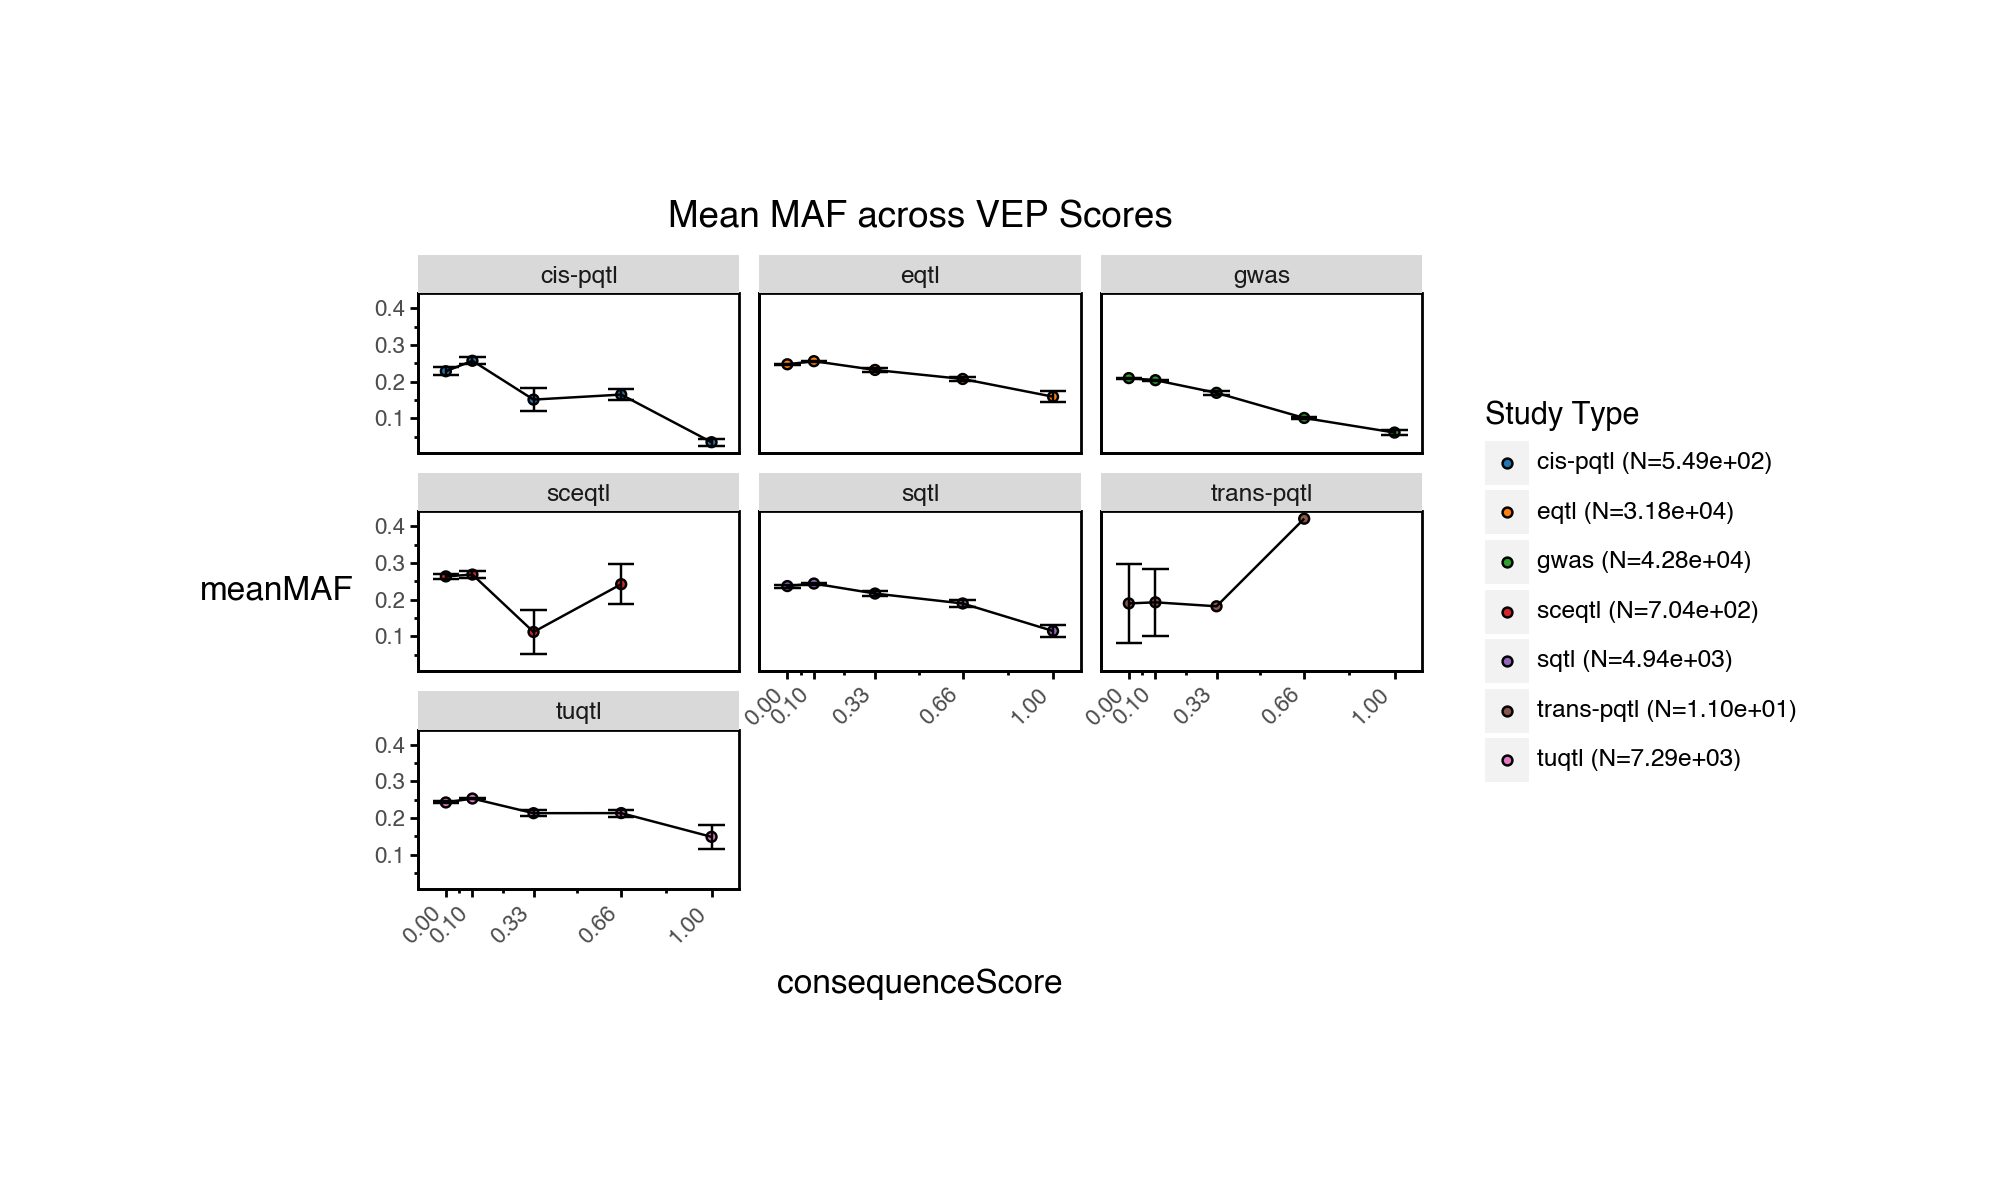

In [ ]:
data = replicated_gwas_credible_sets.orderBy(f.desc("consequenceScore")).toPandas()
cs_counts = data[["nCredibleSets", "studyType"]]
study_type_totals = data.groupby("studyType")["nCredibleSets"].sum()
totals_map = {cat: f"{cat} (N={study_type_totals[cat]:.2e})" for cat in study_type_totals.index}

plot = (
    pn.ggplot(data, pn.aes(y="meanMAF", x="consequenceScore", fill="studyType"))
    + pn.geom_point()
    + pn.geom_errorbar(pn.aes(ymin="meanMAF - stdErrMAF", ymax="meanMAF + stdErrMAF"), width=0.1)
    + pn.geom_line()
    + pn.labs(title="Mean MAF across VEP Scores")
    + pn.theme(
        figure_size=(10, 6),  # ~85mm wide
        axis_title_x=pn.element_text(size=REM * 1.2, family="sans-serif"),
        axis_text=pn.element_text(size=REM * 0.8, family="sans-serif"),
        axis_title_y=pn.element_text(size=REM * 1.2, family="sans-serif", rotation=0, vjust=0.5),
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        axis_ticks=pn.element_line(color="black"),
        axis_line=pn.element_line(color="black"),
        panel_background=pn.element_rect(fill="white"),
        panel_border=pn.element_rect(color="black", fill=None),
        panel_grid=pn.element_blank(),
        plot_margin=0.1,
    )
    + pn.scale_x_continuous(
        breaks=[x for x in data["consequenceScore"].unique()],
        labels=[f"{x:.2f}" for x in data["consequenceScore"].unique()],
    )
    + pn.facet_wrap(nrow=3, ncol=3, facets="studyType")
    + pn.scale_fill_manual(
        values=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"],
        name="Study Type",
        labels=totals_map,
    )
)
plot


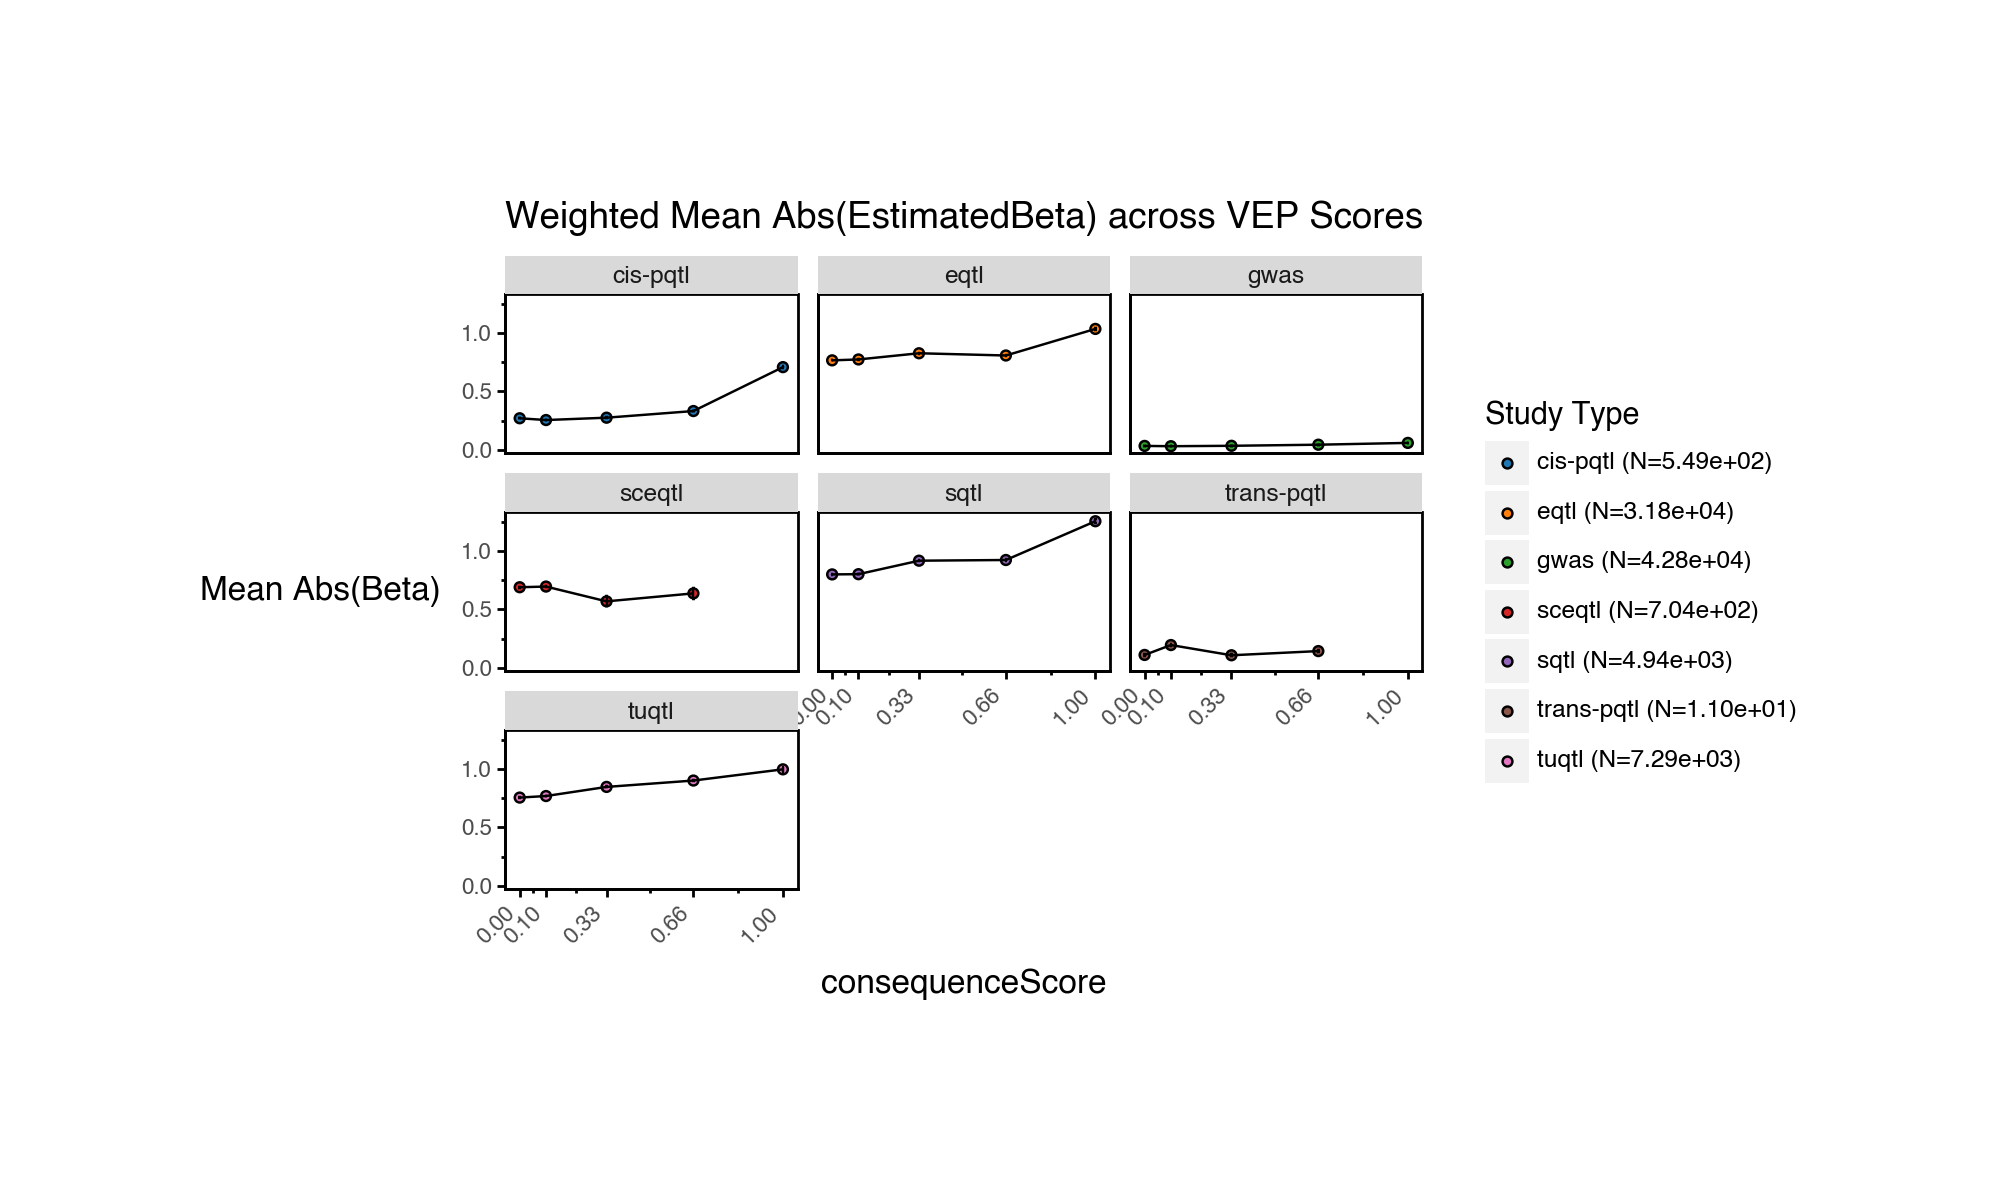

In [62]:
plot = (
    pn.ggplot(data, pn.aes(y="WeightedMeanAbsEstimatedBeta", x="consequenceScore", fill="studyType"))
    + pn.geom_point()
    + pn.geom_errorbar(
        pn.aes(
            ymin="WeightedMeanAbsEstimatedBeta - WeightedSEAbsEstimatedBeta",
            ymax="WeightedMeanAbsEstimatedBeta + WeightedSEAbsEstimatedBeta",
        ),
        width=0.01,
    )
    + pn.geom_line()
    + pn.labs(title="Weighted Mean Abs(EstimatedBeta) across VEP Scores", y="Mean Abs(Beta)")
    + pn.theme(
        figure_size=(10, 6),  # ~85mm wide
        axis_title_x=pn.element_text(size=REM * 1.2, family="sans-serif"),
        axis_text=pn.element_text(size=REM * 0.8, family="sans-serif"),
        axis_title_y=pn.element_text(size=REM * 1.2, family="sans-serif", rotation=0, vjust=0.5),
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        axis_ticks=pn.element_line(color="black"),
        axis_line=pn.element_line(color="black"),
        panel_background=pn.element_rect(fill="white"),
        panel_border=pn.element_rect(color="black", fill=None),
        panel_grid=pn.element_blank(),
        plot_margin=0.1,
    )
    + pn.scale_x_continuous(
        breaks=[x for x in data["consequenceScore"].unique()],
        labels=[f"{x:.2f}" for x in data["consequenceScore"].unique()],
    )
    + pn.facet_wrap(nrow=3, ncol=3, facets="studyType")
    + pn.scale_fill_manual(
        values=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"],
        name="Study Type",
        labels=totals_map,
    )
)
plot
